In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import os, sys

from phm08ds.models import experiment

## Load Dataset

In [3]:
folderpath = '../../data/interim/'
data_completed = pd.read_csv(folderpath + 'data_preprocessed.csv')
data_completed.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state,Operational_condition
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,1,1
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,1,3
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,1,4
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,1,2
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,1,4


## Data preprocessing

Use the pipeline and mlp

In [11]:
from phm08ds.data.preprocessing import OperationalCondition

data_unlabel = data_completed.drop(labels=['Health_state', 'Operational_condition'], axis=1)

tf_op_cond = OperationalCondition()
op_cond = tf_op_cond.fit_transform(data_unlabel.loc[0])

from phm08ds.features.feature_selection import RemoveSensor

tf_select_sensor = RemoveSensor(sensors=[4,5,7,9,15,16,17,18])

data_important_sensors = tf_select_sensor.fit_transform(data_unlabel).iloc[:,5:]

from sklearn.preprocessing import StandardScaler

tf_std = StandardScaler()
data_elman = tf_std.fit_transform(data_important_sensors)

In [12]:
data_important_sensors.head()

,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_6,Sensor_8,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_19,Sensor_20
0,489.05,604.13,1499.45,1309.95,394.88,8770.20,45.40,372.15,2388.13,8120.83,8.6216,28.58,17.1735
1,518.67,642.13,1584.55,1403.96,553.67,9045.76,47.29,521.81,2388.15,8132.87,8.3907,38.99,23.3619
2,449.44,555.42,1368.17,1122.49,194.93,8343.91,41.92,183.26,2387.95,8063.84,9.3557,14.83,8.8555
3,491.19,607.03,1488.44,1249.18,334.82,8721.53,44.26,314.84,2388.07,8052.30,9.2231,24.42,14.7832
4,445.00,549.52,1354.48,1124.32,138.24,8314.56,41.79,130.44,2387.89,8083.67,9.2986,10.99,6.4025


In [4]:
data_elman

array([[ 0.61180613,  0.68653509,  0.71411803, ...,  0.7079022 ,
         0.62225216,  0.41984362],
       [ 1.73123631,  1.81691912,  1.83668347, ...,  1.5341318 ,
         1.09585304,  0.41984362],
       [-0.88517663, -0.70301017, -0.65974064, ..., -0.51348069,
        -0.03667081,  0.41984362],
       ...,
       [-1.05297778, -1.13586454, -1.0779513 , ..., -0.51348069,
        -0.1121724 ,  0.41984362],
       [-0.88517663, -0.70301017, -0.65974064, ..., -0.40571161,
        -0.03667081,  0.41984362],
       [-0.39008766, -0.27015579, -0.47081215, ..., -1.37563332,
        -2.15071532, -2.3818392 ]])

In [5]:
labels = np.array(data_completed['Health_state'])

In [6]:
from sklearn.preprocessing import LabelBinarizer

tf_label_binarize = LabelBinarizer(neg_label=-1)
labels_encoded = tf_label_binarize.fit_transform(labels)

In [7]:
data_important_sensors.to_csv('data_op_01_cleaned.csv')

In [11]:
data_completed['Health_state'].to_csv('data_op_01_cleaned_labels.csv')

# Classification steps

## How to use Elman network of neurolab

Folllowing the example at https://pythonhosted.org/neurolab/ex_newelm.html

In [7]:
import neurolab as nl

In [8]:
min_list = []
max_list = []

for feature in range(0,data_elman.shape[1]):
    min_list.append(data_elman[:,feature].min())
    max_list.append(data_elman[:,feature].max())
    
min_max_list = list(map(list, list(zip(min_list, max_list))))
min_max_list

[[-1.0529777759307313, 1.7312363125165662],
 [-1.1358645396673506, 1.8169191224769112],
 [-1.0797855524444744, 1.8366834680259683],
 [-2.1538354187812554, 1.098730161182202],
 [-1.2905496553802565, 1.6039106409075758],
 [-0.7104703701161955, 1.407518233077691],
 [-1.6270945046492944, 1.7855929859754065],
 [-2.1507153249002773, 1.0958530395659347],
 [-2.3818391992796486, 0.4198436234916414]]

from sklearn.preprocessing import LabelBinarizer

target_tf = LabelBinarizer()
labels_encoded = target_tf.fit_transform(labels_op_1)

In [9]:
elman_clf = nl.net.newelm(min_max_list, [50,4], [nl.trans.TanSig(), nl.trans.PureLin()])

In [10]:
# Set initialized functions and init
elman_clf.layers[0].initf = nl.init.InitRand([-0.01, 0.01], 'w')
elman_clf.layers[1].initf= nl.init.InitRand([-0.01, 0.01], 'w')

# elman_clf.layers[0].initf = nl.init.initnw(1)
# elman_clf.layers[1].initf= nl.init.initnw([-0.1, 0.1], 'wb')
elman_clf.init()

In [11]:
# Train network
error = elman_clf.train(data_elman, labels_encoded, epochs=10, goal=0.1, adapt=True, show=1)
# Simulate network
output = elman_clf.sim(data_elman)

Epoch: 1; Error: 0.9942755135527783;
Epoch: 2; Error: 0.6535217417650678;


/home/navar/anaconda3/lib/python3.6/site-packages/neurolab/layer.py:49: RuntimeWarning: overflow encountered in multiply
  self.s = np.sum(self.np['w'] * inp, axis=1)
/home/navar/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Epoch: 3; Error: nan;
Epoch: 4; Error: nan;
Epoch: 5; Error: nan;
Epoch: 6; Error: nan;
Epoch: 7; Error: nan;
Epoch: 8; Error: nan;
Epoch: 9; Error: nan;
Epoch: 10; Error: nan;
The maximum number of train epochs is reached


In [12]:
error

[0.9942755135527783,
 0.6535217417650678,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

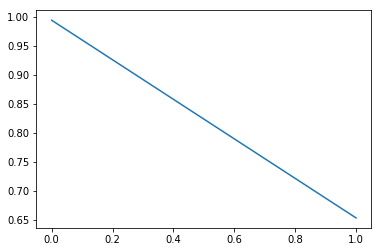

In [13]:
plt.plot(error)

### Test the newtwork

In [14]:
real_targets = labels.reshape(-1)
real_targets

array([1, 1, 1, ..., 4, 4, 4])

In [15]:
predicted_targets = tf_label_binarize.inverse_transform(output)

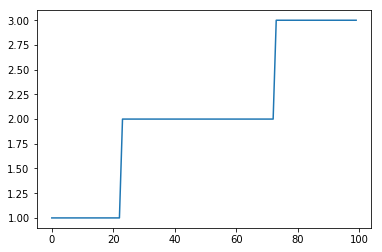

In [16]:
until_to = 100

plt.figure()
plt.plot(real_targets[:until_to])
plt.plot(output[:until_to])

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(real_targets, predicted_targets)

0.1100875473670456

In [19]:
confusion_matrix(real_targets, predicted_targets)

array([[ 5055,     0,     0,     0],
       [ 8278,     0,     0,     0],
       [21467,     0,     0,     0],
       [11118,     0,     0,     0]])